In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import pandas as pd

### Functions

In [2]:
def select_maximum(x):
    amp_max = 0
    charge = 0
    for amp in x:
        charge += amp
        if amp_max < amp:
            amp_max = amp
    return (amp_max,charge)

In [3]:
def select_time(x,amp_max):
    time_i = 0
    for amp in x:
        if amp >= 0.25 * amp_max:
            return time_i
        time_i +=1
    return time_i

In [4]:
def max_number(x):
    i = 0
    n_max = 0
    max_val = []
    for i in range(2,61):
        if (x[i-2] <= x[i-1] <x[i] > x[i+1] >= x[i+2]):
            n_max += 1
            max_val.append(x[i])
    return n_max,max_val   

In [6]:
df = pd.DataFrame({'Channel':[], 'Amplitude':[], 'Charge':[], 'n_max':[]})

In [7]:
for i in range (1,9):
    file_name = f"../data/test_{i}.txt"
    print(file_name)
    with open(file_name) as f_in1, open(file_name) as f_in2 :
        f1 = itertools.islice(f_in1, 0, None, 3)
        f2 = itertools.islice(f_in2, 2, None, 3)
        y = np.genfromtxt(f1, delimiter="    ",autostrip=True, comments="=", usecols=np.arange(2,64))
        hits = np.genfromtxt(f2, delimiter=" ",autostrip=True, comments="=",usecols=(1))

    i = 0
    ampl = np.zeros(hits.size)
    charge = np.zeros(hits.size)
    nmax = np.zeros(hits.size)
    for y_l in y:
        nmax[i], test =  max_number(y_l)
        y_l =-1 *(y_l - 0.78)
        ampl[i], charge[i] = select_maximum(y_l)
        i+=1
    df = df.append(pd.DataFrame({'Channel':hits, 'Amplitude':ampl, 'Charge':charge, 'n_max':nmax}))

../data/test_1.txt


KeyboardInterrupt: 

### Work on subset file

In [5]:
file_name = f"../data/test_1.txt"
with open(file_name) as f_in1, open(file_name) as f_in2 :
    f1 = itertools.islice(f_in1, 0, None, 3)
    f2 = itertools.islice(f_in2, 2, None, 3)
    y = np.genfromtxt(f1, delimiter="    ",autostrip=True, comments="=", usecols=np.arange(2,64))
    hits = np.genfromtxt(f2, delimiter=" ",autostrip=True, comments="=",usecols=(1))

In [10]:
nrow, ncol = y.shape

In [16]:
y =-1 *(y - 0.78)

In [6]:
import sys
sys.path.append("../scripts/")
from extract_data import *
freq = 3.2e9
t = 1/freq
time_ = np.arange(0,63) * t

SyntaxError: unexpected EOF while parsing (extract_data.py, line 41)

In [12]:
freq = 3.2e9
t = 1/freq
time_ = np.arange(0,ncol) * t

In [63]:
import imp
imp.reload(extract_data)

NameError: name 'extract_data' is not defined

In [8]:
def draw_pulse(ax,fig,x,y,n_pulse):
    ax.clear()
    col = np.random.rand(3,)
    ax.fill_between(x,y[n_pulse], alpha=0.2, facecolor=col)
    ax.plot(x,y[n_pulse],c=col, label=f'pulse #{n_pulse}')
    ax.legend()
    fig.canvas.draw()

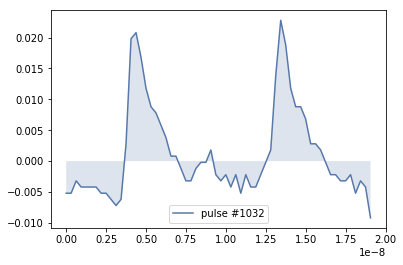

In [256]:
fig,ax = plt.subplots(1,1)
draw_pulse(ax,fig,time_,(y -  baselines.reshape(nrow,1)),1032)  

### Baseline computation

In [21]:
nrow, ncol  = y.shape #Gets number of rows (hits) and columns (points/pulses) in the selection of hits
max_arg = np.argmax(y,1) # Gets the array of all the max amplitude position
good_max_arg = max_arg[:,None] * np.ones((nrow,ncol)) 
count = np.arange(1,ncol+1)[None] * np.ones((nrow,ncol)) 
y_baseline = np.copy(y)
y_baseline[good_max_arg -3 < count] = 0 # Creates the pulses array (y) but with only the amplitude values 3 bins before the max
baselines = y_baseline.sum(axis=1)/(max_arg-3) # Measure the average of the baseline

/home/roy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


### Amplitude computation

In [25]:
ampl = y.max(1) - baselines # Gets the maximum of every hit. Removes the baseline

### Charge computation

In [40]:
charge = (y - baselines.reshape(nrow,1)).sum(1)  * ((nrow - (max_arg-3)) * t) # somme des (Bins - baseline) * temps du permier pic à la fin

### Compute the number of peaks
We define a peak as a bin with Ai-2 < Ai-1 < Ai > Ai+1 > Ai+2

In [275]:
f_col = np.array([False]*nrow).reshape(nrow,1)
ff_col = np.array([False,False]*nrow).reshape(nrow,2)

In [276]:
val_sup = np.hstack([f_col,(y[:,1:] > y[:,:-1])]) # Ai > Ai-1
val_inf =  np.hstack([(y[:,:-1] > y[:,1:]),f_col]) # Ai > Ai+1
prev_sup = np.hstack([ff_col,(y[:,1:-1]>=y[:,:-2])]) # Ai-1 >= Ai-2
prev_inf = np.hstack([(y[:,1:-1] >= y[:,2:]),ff_col]) # Ai+1 >= Ai+2

In [277]:
tot_peak = (val_sup & val_inf & prev_sup & prev_inf)

In [312]:
nmax = tot_peak.sum(1)

Test on an event

3


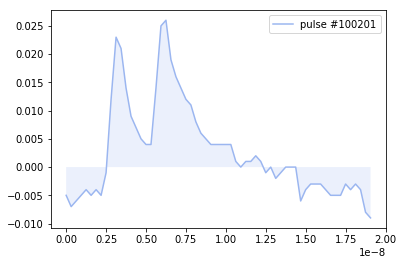

In [289]:
print(tot_peak.sum(1)[100201])
fig,ax = plt.subplots(1,1)
draw_pulse(ax,fig,time_,(y ),100201)  

In [291]:
print(np.where([tot_peak[100201]])[1])
print(y[100201,10],10*t*1e8)
print(y[100201,20],20*t*1e8)
print(y[100201,38],38*t*1e8)

[10 20 38]
0.02300000000000002 0.3125
0.026000000000000023 0.625
0.0020000000000000018 1.1875


### Compute time of peak (0.25 * max amplitude - Rising edge)

In [311]:
time_pulses = np.argmax(y - baselines.reshape(nrow,1)>0.25*ampl.reshape(nrow,1),1) * t

/home/roy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [303]:
aa = np.array([[1,2,3],[1,2,5],[0,3,2]])
ab = np.array([[2],[1],[-1]])

In [305]:
np.argmax(aa>ab,1)

array([2, 1, 0])

In [314]:
df = pd.DataFrame({'Channel':[], 'Amplitude':[], 'Charge':[], 'n_max':[], 'time':[]})

In [315]:
 df = df.append(pd.DataFrame({'Channel':hits, 'Amplitude':ampl, 'Charge':charge, 'n_max':nmax, 'time':time_pulses}))

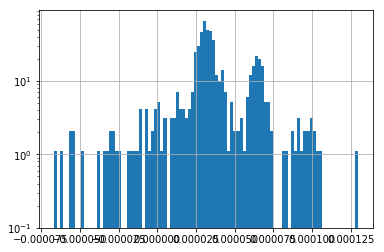

In [339]:
fig, ax = plt.subplots()
df["Charge"][(df["Channel"] == 6) & (df["n_max"] == 1)].hist(ax=ax, bins=100, bottom=0.1)
ax.set_yscale('log')